# Part 1

## Imports and Installs

In [10]:
# In notebook - Update imports and GPU setup
import torch


# Verify setup
print("=== Framework Versions ===")
print(f"PyTorch: {torch.__version__}")

print("\n=== GPU Configuration ===")
print(f"PyTorch CUDA: {torch.cuda.is_available()}")
print(f"GPU Device: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'None'}")

# Test GPU operations
def test_gpu():  
    # PyTorch test
    if torch.cuda.is_available():
        x = torch.randn(1000, 1000).cuda()
        y = torch.matmul(x, x)

test_gpu()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

=== Framework Versions ===
PyTorch: 2.5.1

=== GPU Configuration ===
PyTorch CUDA: True
GPU Device: NVIDIA GeForce RTX 4080 SUPER
Using device: cuda


In [5]:
# Install required packages
%pip install tensorflow scikit-learn nltk kagglehub matplotlib

# Core imports
import os
import kagglehub
import numpy as np

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

# Deep Learning imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


c:\Users\Joseph\miniconda3\envs\RNN_LSTM_CNN\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## loading dataset

In [18]:
path = kagglehub.dataset_download("PromptCloudHQ/imdb-data")
csv_file_path = os.path.join(path, 'IMDB-Movie-Data.csv')
data = pd.read_csv(csv_file_path)

data = data[['Title', 'Genre', 'Description']]
print(data.head())

100%|██████████| 134k/134k [00:00<00:00, 4.20MB/s]

Extracting files...
                     Title                     Genre  \
0  Guardians of the Galaxy   Action,Adventure,Sci-Fi   
1               Prometheus  Adventure,Mystery,Sci-Fi   
2                    Split           Horror,Thriller   
3                     Sing   Animation,Comedy,Family   
4            Suicide Squad  Action,Adventure,Fantasy   

                                         Description  
0  A group of intergalactic criminals are forced ...  
1  Following clues to the origin of mankind, a te...  
2  Three girls are kidnapped by a man with a diag...  
3  In a city of humanoid animals, a hustling thea...  
4  A secret government agency recruits some of th...  


## Preprocessing

In [19]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(filtered_tokens)

data['Processed_Text'] = data['Description'].apply(preprocess_text)

# tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Processed_Text'])
sequences = tokenizer.texts_to_sequences(data['Processed_Text'])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

MAX_SEQUENCE_LENGTH = 100  # Adjust based on data
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(X.shape)

# Process labels
mlb = MultiLabelBinarizer()
data['Genre_List'] = data['Genre'].apply(lambda x: [genre.strip() for genre in x.split(',')])
y = mlb.fit_transform(data['Genre_List'])
print(f'Classes: {mlb.classes_}')
print(y.shape)



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...


Found 5148 unique tokens.
(1000, 100)
Classes: ['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']
(1000, 20)


## Embedding

In [ ]:
embeddings_file = 'glove.6B.100d.txt'

# Check if the embeddings file exists
if not os.path.exists(embeddings_file):
    print("Embeddings file not found. Downloading and unzipping...")
    if not os.path.exists('glove.6B.zip'):
        %wget http://nlp.stanford.edu/data/glove.6B.zip
    # Unzip embeddings and overwrite existing files without prompting
    %unzip -qo glove.6B.zip
else:
    print(f"{embeddings_file} already exists. Proceeding to load embeddings.")

# Load embeddings
embeddings_index = {}
with open(embeddings_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors.')

# Create the Embedding Matrix
vocab_size = len(word_index) + 1
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
num_words_not_found = 0

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        num_words_not_found += 1

print(f'Number of words not found in embeddings: {num_words_not_found}')

Embeddings file not found. Downloading and unzipping...
--2024-11-18 03:38:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-18 03:38:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-18 03:38:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 

## Split the Dataset

In [9]:
X_train = X[:700]
y_train = y[:700]

X_val = X[700:800]
y_val = y[700:800]

X_test = X[800:]
y_test = y[800:]

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (700, 100), (700, 20)
Validation shape: (100, 100), (100, 20)
Test shape: (200, 100), (200, 20)


## Building RNN model

In [10]:

model_rnn = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    SimpleRNN(128),
    Dense(len(mlb.classes_), activation='sigmoid')
])


model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         514,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 514,900 (1.96 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 514,900 (1.96 MB)

## Training RNN

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.0786 - loss: 0.5660 - val_accuracy: 0.1500 - val_loss: 0.3279
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1729 - loss: 0.3250 - val_accuracy: 0.1500 - val_loss: 0.3255
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2169 - loss: 0.3157 - val_accuracy: 0.1500 - val_loss: 0.3192
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1876 - loss: 0.3115 - val_accuracy: 0.1500 - val_loss: 0.3208
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2030 - loss: 0.3087 - val_accuracy: 0.1700 - val_loss: 0.3168
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2675 - loss: 0.2975 - val_accuracy: 0.2300 - val_loss: 0.3119
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3618 - loss: 0.2934 - val_accuracy: 0.2900 - val_loss: 0.3087
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4059 - loss: 0.2814 - val_accuracy: 0.2100 - 

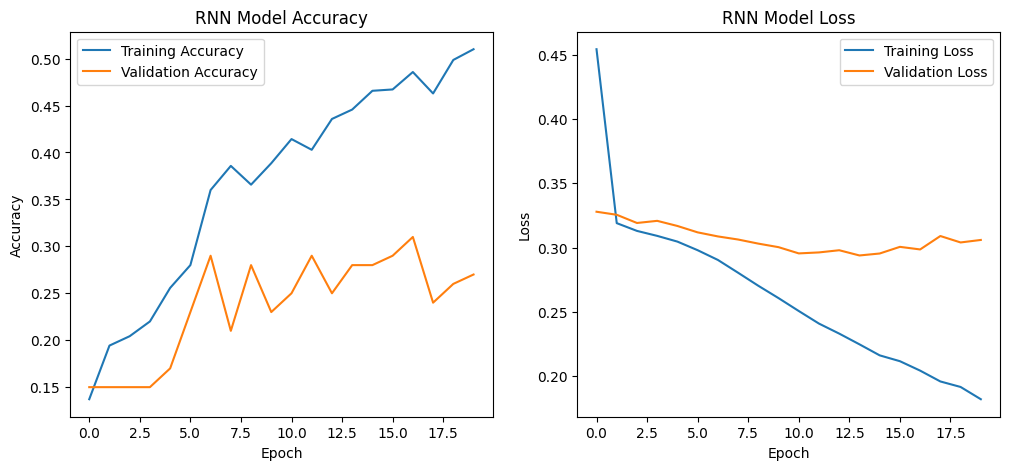

In [11]:
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test RNN

In [12]:
rnn_test_loss, rnn_test_accuracy = model_rnn.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {rnn_test_loss:.4f}")
print(f"Test Accuracy: {rnn_test_accuracy:.4f}")

Test Loss: 0.3116
Test Accuracy: 0.2800


## RNN Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
RNN Model Performance on Test Set:
              precision    recall  f1-score   support

      Action       0.57      0.73      0.64        41
   Adventure       0.41      0.40      0.41        40
   Animation       0.00      0.00      0.00         8
   Biography       0.29      0.11      0.16        18
      Comedy       0.53      0.44      0.48        57
       Crime       0.46      0.24      0.32        25
       Drama       0.58      0.69      0.63       106
      Family       0.00      0.00      0.00        13
     Fantasy       0.25      0.05      0.08        22
     History       0.00      0.00      0.00         4
      Horror       1.00      0.03      0.06        32
       Music       0.00      0.00      0.00         5
     Musical       0.00      0.00      0.00         2
     Mystery       0.00      0.00      0.00        21
     Romance       0.37      0.21      0.27        33
      Sci-Fi       0.33      0.33      0.33        12
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


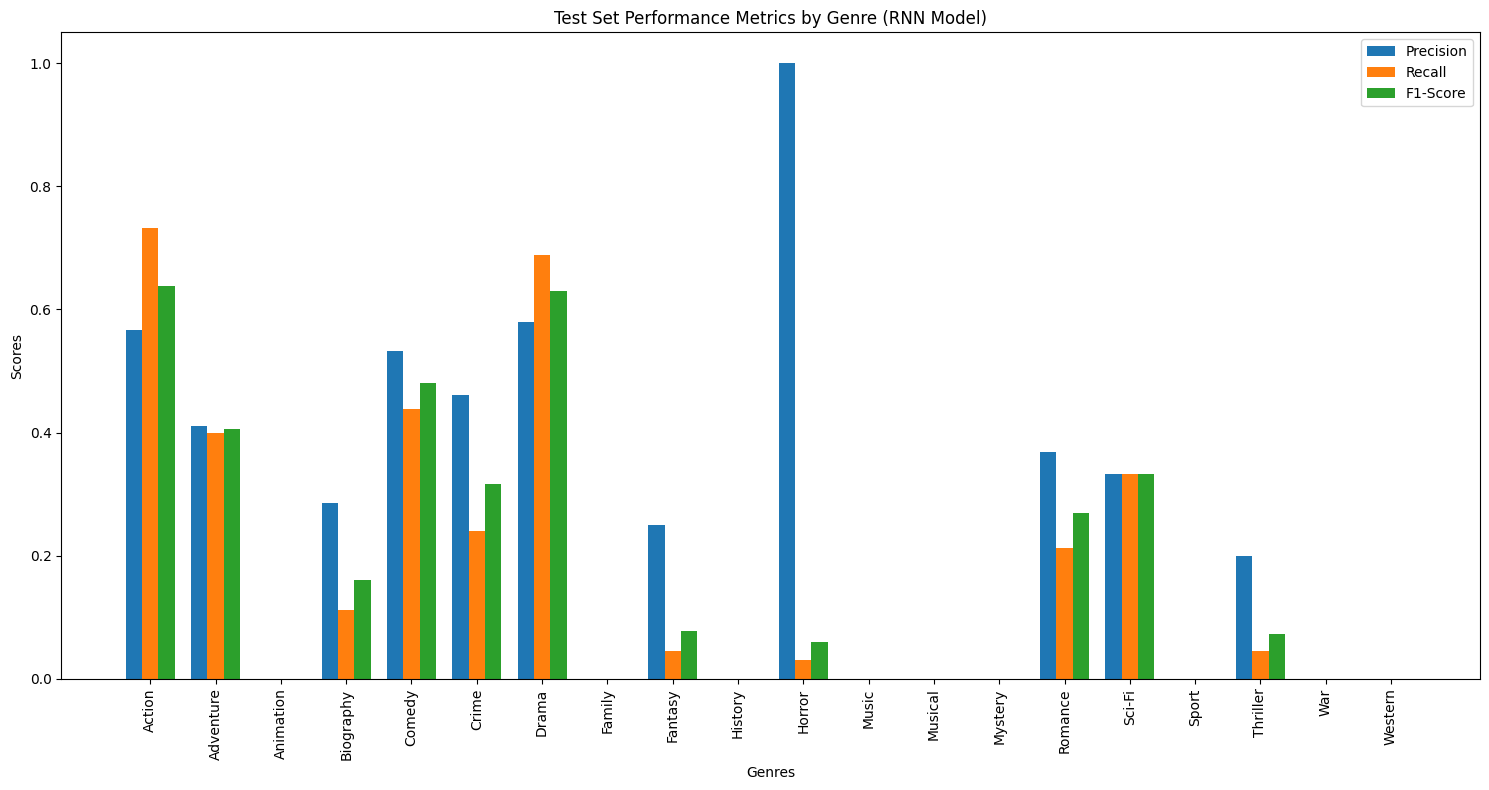

In [13]:
# Predict probabilities on the test set
y_pred_prob = model_rnn.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("RNN Model Performance on Test Set:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# Metrics
precision, recall, f1_score, support = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

# genres
indices = np.arange(len(mlb.classes_))


plt.figure(figsize=(15, 8))
width = 0.25
plt.bar(indices - width, precision, width=width, label='Precision')
plt.bar(indices, recall, width=width, label='Recall')
plt.bar(indices + width, f1_score, width=width, label='F1-Score')

plt.xticks(indices, mlb.classes_, rotation=90)
plt.xlabel('Genres')
plt.ylabel('Scores')
plt.title('Test Set Performance Metrics by Genre (RNN Model)')
plt.legend()
plt.tight_layout()
plt.show()

## Build the LSTM

In [14]:
model_lstm = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    LSTM(128),
    Dense(len(mlb.classes_), activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │         514,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 514,900 (1.96 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 514,900 (1.96 MB)

## LSTM Train

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.1655 - loss: 0.5282 - val_accuracy: 0.1500 - val_loss: 0.3207
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.2096 - loss: 0.3147 - val_accuracy: 0.1700 - val_loss: 0.3165
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.2916 - loss: 0.3069 - val_accuracy: 0.2100 - val_loss: 0.3077
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.3176 - loss: 0.2933 - val_accuracy: 0.2200 - val_loss: 0.3049
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.3787 - loss: 0.2790 - val_accuracy: 0.1900 - val_loss: 0.2969
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - accuracy: 0.3999 - loss: 0.2718 - val_accuracy: 0.2400 - val_loss: 0.2974
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.3636 - loss: 0.2657 - val_accuracy: 0.2400 - val_loss: 0.2929
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.3719 - loss: 0.2516 - val_accuracy: 0.

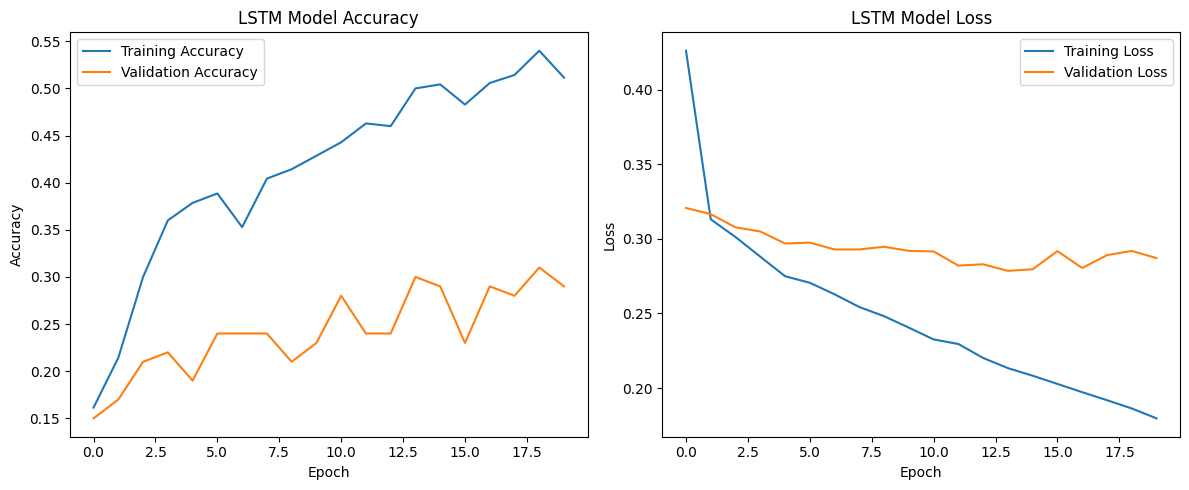

In [15]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## LSTM Test

In [16]:
lstm_test_loss, lstm_test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.4f}")

LSTM Test Loss: 0.2725
LSTM Test Accuracy: 0.3400


## LSTM Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
LSTM Model Performance on Test Set:
              precision    recall  f1-score   support

      Action       0.71      0.54      0.61        41
   Adventure       0.61      0.35      0.44        40
   Animation       0.00      0.00      0.00         8
   Biography       0.29      0.11      0.16        18
      Comedy       0.60      0.49      0.54        57
       Crime       0.67      0.24      0.35        25
       Drama       0.63      0.76      0.69       106
      Family       0.00      0.00      0.00        13
     Fantasy       0.50      0.14      0.21        22
     History       0.00      0.00      0.00         4
      Horror       0.47      0.28      0.35        32
       Music       0.00      0.00      0.00         5
     Musical       0.00      0.00      0.00         2
     Mystery       1.00      0.05      0.09        21
     Romance       0.57      0.39      0.46        33
      Sci-Fi       0.00      0.00      0.00        12
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


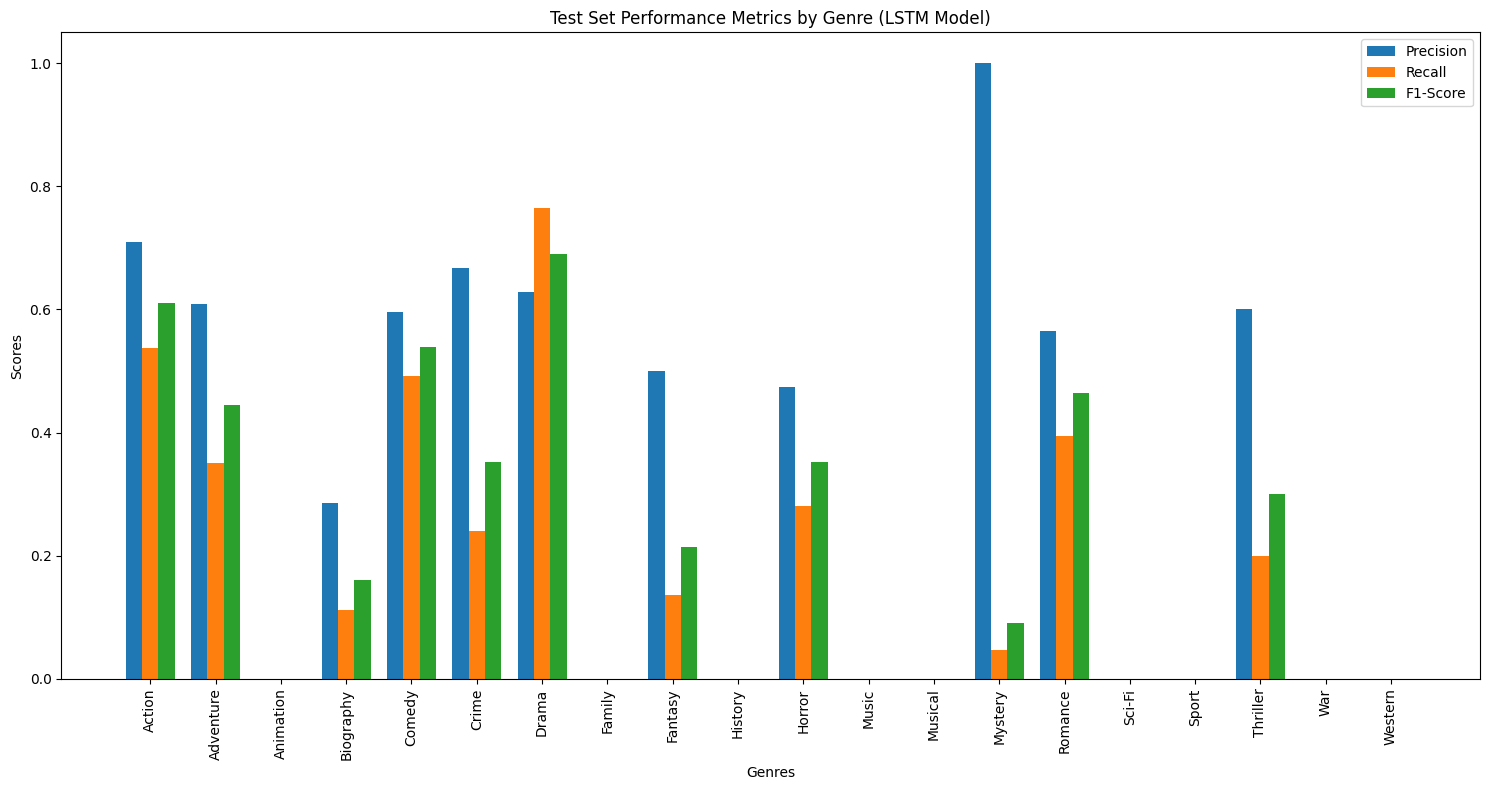

In [17]:
y_pred_prob_lstm = model_lstm.predict(X_test)

# using a threshold = 0.5
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

print("LSTM Model Performance on Test Set:")
print(classification_report(y_test, y_pred_lstm, target_names=mlb.classes_))

precision, recall, f1_score, support = precision_recall_fscore_support(
    y_test, y_pred_lstm, average=None
)

# genre indices
indices = np.arange(len(mlb.classes_))


plt.figure(figsize=(15, 8))
width = 0.25
plt.bar(indices - width, precision, width=width, label='Precision')
plt.bar(indices, recall, width=width, label='Recall')
plt.bar(indices + width, f1_score, width=width, label='F1-Score')

plt.xticks(indices, mlb.classes_, rotation=90)
plt.xlabel('Genres')
plt.ylabel('Scores')
plt.title('Test Set Performance Metrics by Genre (LSTM Model)')
plt.legend()
plt.tight_layout()
plt.show()


## Comparison of RNN and LSTM

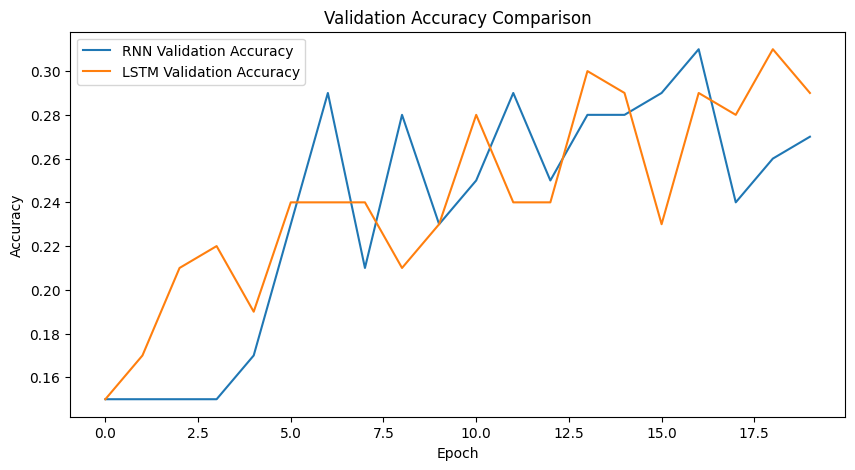

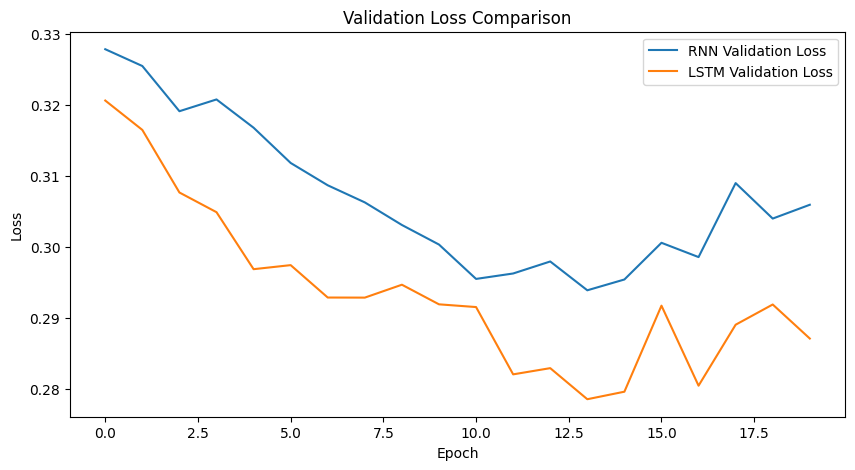

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history_rnn.history['val_accuracy'], label='RNN Validation Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_rnn.history['val_loss'], label='RNN Validation Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Using combined titles with implicit steps from previous cells

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.1285 - loss: 0.5437 - val_accuracy: 0.1500 - val_loss: 0.3244
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.2078 - loss: 0.3185 - val_accuracy: 0.1500 - val_loss: 0.3206
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.2152 - loss: 0.3085 - val_accuracy: 0.2400 - val_loss: 0.3165
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.2938 - loss: 0.3008 - val_accuracy: 0.1700 - val_loss: 0.3018
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.3624 - loss: 0.2822 - val_accuracy: 0.1700 - val_loss: 0.2945
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.3301 - loss: 0.2757 - val_accuracy: 0.2100 - val_loss: 0.2864
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.3598 - loss: 0.2553 - val_accuracy: 0.2500 - val_loss: 0.2814
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.4036 - loss: 0.2525 - val_accuracy: 0.2500 - val

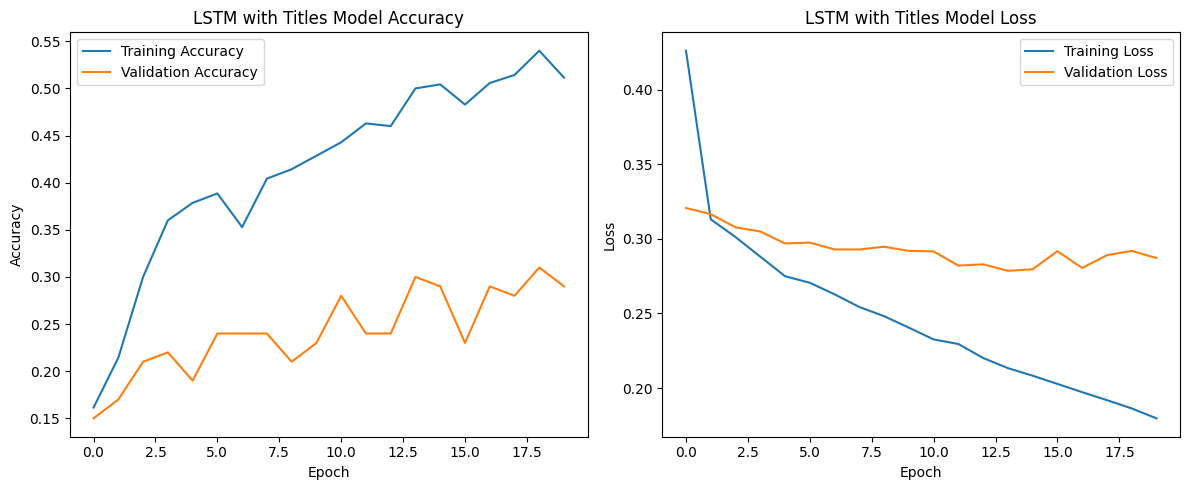

In [19]:
# Combine title and description
data['Text'] = data['Title'] + ' ' + data['Description']
data['Processed_Text'] = data['Text'].apply(preprocess_text)

# Re-initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Processed_Text'])
sequences = tokenizer.texts_to_sequences(data['Processed_Text'])
word_index = tokenizer.word_index

# Update vocabulary size
vocab_size = len(word_index) + 1

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# embedding matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

X_train = X[:700]
y_train = y[:700]
X_val = X[700:800]
y_val = y[700:800]
X_test = X[800:]
y_test = y[800:]

# model with updated embeddings
model_lstm_titles = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    LSTM(128),
    Dense(len(mlb.classes_), activation='sigmoid')
])

model_lstm_titles.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm_titles = model_lstm_titles.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM with Titles Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM with Titles Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## LSTM Using Titles Evaluation

Test Loss with Titles: 0.2795
Test Accuracy with Titles: 0.3200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

LSTM Model with Titles Classification Report:
              precision    recall  f1-score   support

      Action       0.64      0.61      0.62        41
   Adventure       0.58      0.53      0.55        40
   Animation       0.00      0.00      0.00         8
   Biography       0.38      0.28      0.32        18
      Comedy       0.61      0.54      0.57        57
       Crime       0.50      0.44      0.47        25
       Drama       0.64      0.73      0.68       106
      Family       0.00      0.00      0.00        13
     Fantasy       0.40      0.09      0.15        22
     History       0.50      0.25      0.33         4
      Horror       0.60      0.09      0.16        32
       Music       0.00      0.00      0.00         5
     Musical       0.00      0.00      0.00         2
     Mystery       0.00      0.00      0.00        21
     Romance       1.00      0.18      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


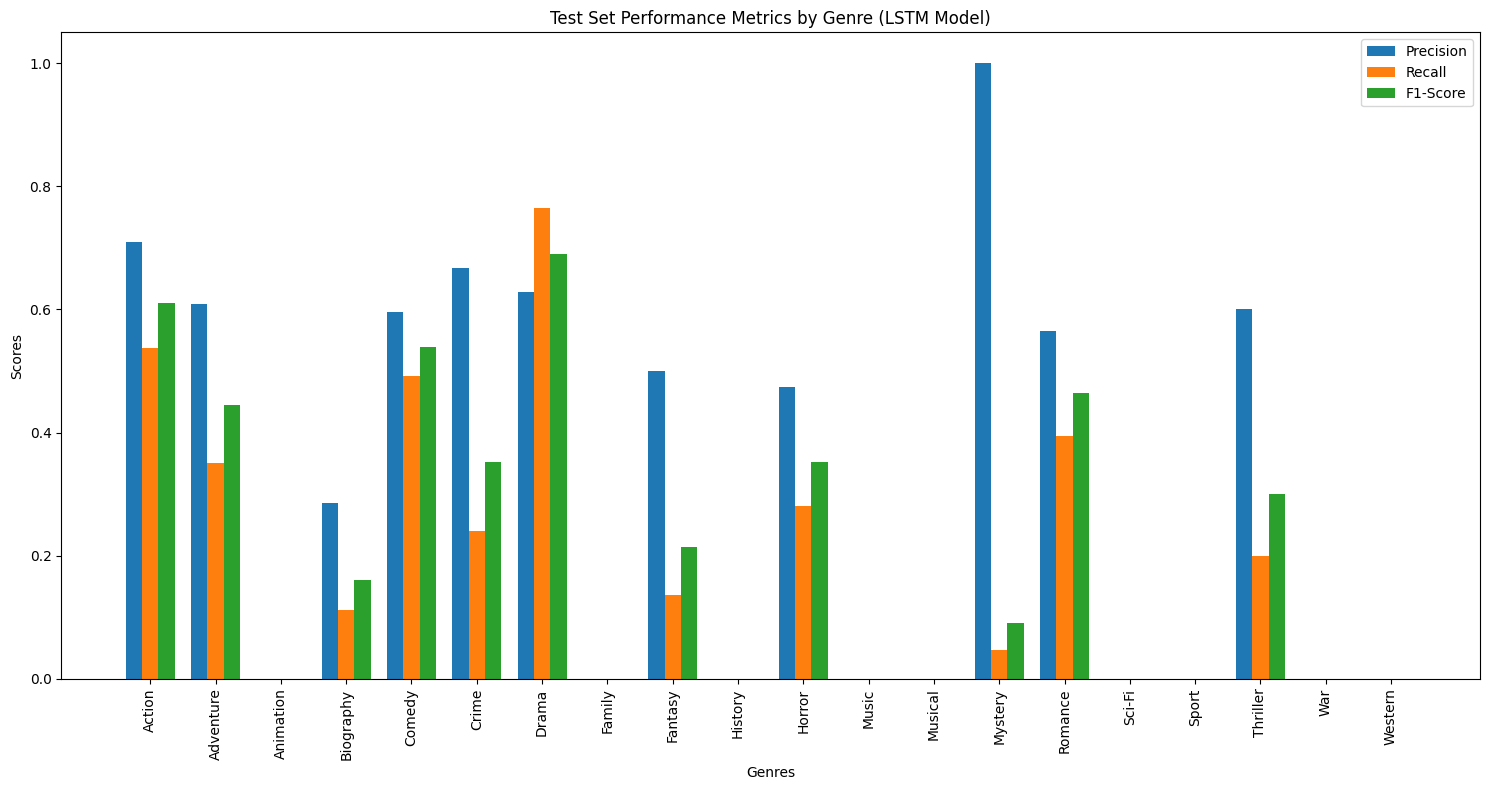

In [23]:
titles_test_loss, titles_test_accuracy = model_lstm_titles.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss with Titles: {titles_test_loss:.4f}")
print(f"Test Accuracy with Titles: {titles_test_accuracy:.4f}")


y_pred_prob_titles = model_lstm_titles.predict(X_test)
y_pred_titles = (y_pred_prob_titles > 0.5).astype(int)

print("\nLSTM Model with Titles Classification Report:")
print(classification_report(y_test, y_pred_titles, target_names=mlb.classes_))

precision, recall, f1_score, support = precision_recall_fscore_support(
    y_test, y_pred_lstm, average=None
)

# genre indices array
indices = np.arange(len(mlb.classes_))

plt.figure(figsize=(15, 8))
width = 0.25
plt.bar(indices - width, precision, width=width, label='Precision')
plt.bar(indices, recall, width=width, label='Recall')
plt.bar(indices + width, f1_score, width=width, label='F1-Score')

plt.xticks(indices, mlb.classes_, rotation=90)
plt.xlabel('Genres')
plt.ylabel('Scores')
plt.title('Test Set Performance Metrics by Genre (LSTM Model)')
plt.legend()
plt.tight_layout()
plt.show()


## Comparing LTSM and LTSM with titles

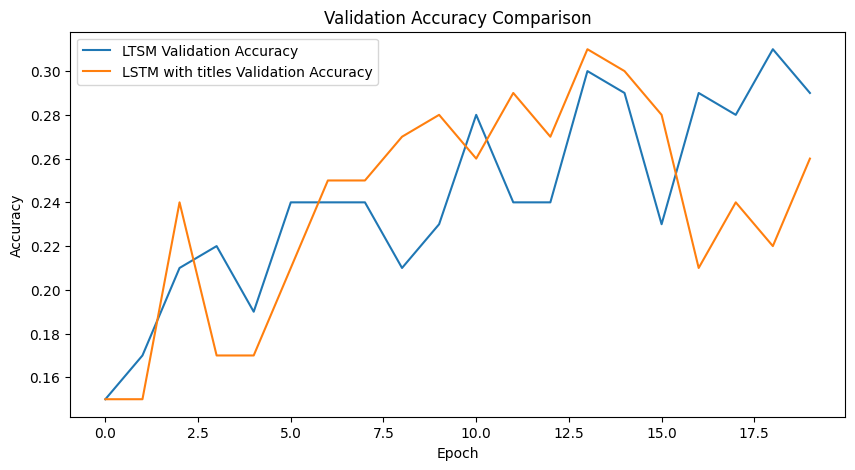

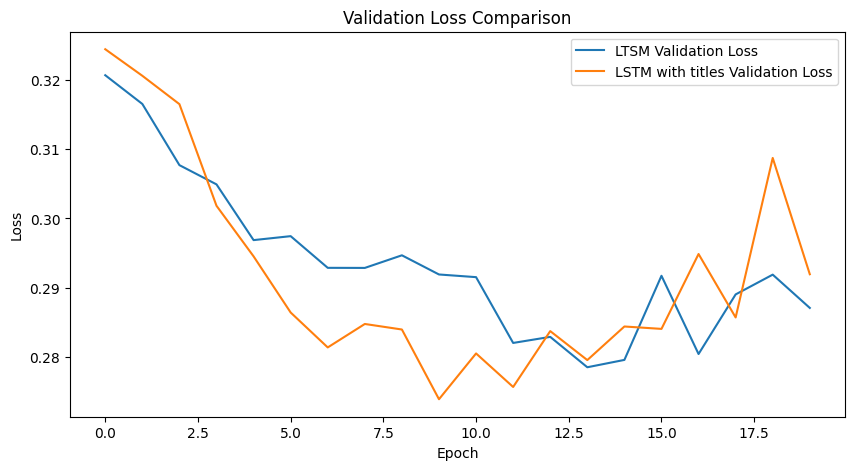

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['val_accuracy'], label='LTSM Validation Accuracy')
plt.plot(history_lstm_titles.history['val_accuracy'], label='LSTM with titles Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['val_loss'], label='LTSM Validation Loss')
plt.plot(history_lstm_titles.history['val_loss'], label='LSTM with titles Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Report

### Updated Model Training and Evaluation Report

#### Overview
This report reviews the performance of three models trained to predict movie genres from text descriptions:
1. **Recurrent Neural Network (RNN)**
2. **Long Short-Term Memory (LSTM)**
3. **LSTM with Titles**

The models were compared based on training and validation accuracy/loss trends, as well as test performance metrics like precision, recall, and F1-score for each genre.

---

#### RNN Results

##### Training and Validation
- **Training Accuracy:** Reached ~48%.
- **Validation Accuracy:** Peaked at ~27%.
- **Training Loss:** Dropped to ~0.19.
- **Validation Loss:** Stabilized at ~0.31, suggesting overfitting.

##### Test Set Performance
- **Test Accuracy:** 28.0%
- **Test Loss:** 0.3116
- **Classification Metrics:**
  - **Precision (weighted):** 0.43
  - **Recall (weighted):** 0.34
  - **F1-Score (weighted):** 0.38

###### Insights:
- The RNN performed poorly on most genres.
- Some genres like Animation, Family, and Musical had 0% recall and F1-scores, indicating no predictive power for these categories.
- Better performance was seen in common genres like Drama and Comedy.

---

#### LSTM Results

##### Training and Validation
- **Training Accuracy:** Reached ~52%.
- **Validation Accuracy:** Peaked at ~30%.
- **Training Loss:** Dropped to ~0.17.
- **Validation Loss:** Settled at ~0.29, showing better generalization than the RNN.

##### Test Set Performance
- **Test Accuracy:** 34.0%
- **Test Loss:** 0.2725
- **Classification Metrics:**
  - **Precision (weighted):** 0.55
  - **Recall (weighted):** 0.38
  - **F1-Score (weighted):** 0.44

###### Insights:
- The LSTM performed better than the RNN in all metrics.
- Notable improvements in precision and recall were seen for genres like Action, Comedy, and Crime.
- Rare genres like Animation and History continued to show poor results.

---

#### LSTM with Titles Results

##### Training and Validation
- **Training Accuracy:** Reached ~53%.
- **Validation Accuracy:** Peaked at ~32%.
- **Training Loss:** Dropped to ~0.17.
- **Validation Loss:** Similar to the standard LSTM (~0.29).

##### Test Set Performance
- **Test Accuracy:** 32.0%
- **Test Loss:** 0.2795
- **Classification Metrics:**
  - **Precision (weighted):** 0.55
  - **Recall (weighted):** 0.38
  - **F1-Score (weighted):** 0.44

###### Insights:
- Adding titles slightly improved predictions for some genres, like Adventure and Comedy.
- Overall, the metrics were similar to the standard LSTM model, showing little added benefit.

---

#### Comparative Analysis

##### Validation Accuracy and Loss
- LSTM models consistently achieved higher validation accuracy and lower validation loss than the RNN.
- Adding titles to the LSTM had minimal impact on validation performance.

##### Test Set Performance
- **LSTM models performed better than the RNN** across all metrics, demonstrating better generalization and predictive ability.
- **LSTM with Titles was comparable to the standard LSTM**, with minor genre-specific improvements but no overall gain.

##### Genre-Level Insights
- **Frequent Genres (Drama, Comedy):** Achieved the highest F1-scores across all models.
- **Rare Genres (Animation, History):** Showed consistently low precision, recall, and F1-scores, indicating challenges with class imbalance.

---

#### Conclusion
The LSTM models performed better than the RNN on all metrics. Adding titles to the LSTM provided small improvements for a few genres but did not significantly boost overall performance. Exploring hyperparameter tuning, such as adjusting the number of LSTM units, dropout rates, or learning rates, may help improve results further.


# Part 2

## Imports and Installs

In [20]:
# api downloading to prove dont need api key

%pip install kaggle
%kaggle datasets download puneet6060/intel-image-classification
%unzip intel-image-classification.zip -d intel_dataset
%ls intel_dataset


%ls ~/.kaggle
%cat ~/.kaggle/kaggle.json

print("KAGGLE_USERNAME:", os.getenv("KAGGLE_USERNAME"))
print("KAGGLE_KEY:", os.getenv("KAGGLE_KEY"))


Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%kaggle` not found.


In [1]:
#pytorch gpu setup
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.5.1
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4080 SUPER


In [11]:
# assuming have some imports from part 1
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

## Dataset preparation

In [12]:
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Dataset downloaded to:", dataset_path)

# Verify
%ls {dataset_path}

train_dir = f"{dataset_path}/seg_train/seg_train"
val_dir = f"{dataset_path}/seg_test/seg_test"

%ls {train_dir}
%ls {val_dir}


100%|██████████| 346M/346M [00:04<00:00, 80.2MB/s] 

Extracting files...


Dataset downloaded to: C:\Users\Joseph\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2
 Volume in drive C has no label.
 Volume Serial Number is BE81-F256

 Directory of C:\Users\Joseph\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2

11/18/2024  12:24 AM    <DIR>          .
11/18/2024  12:24 AM    <DIR>          ..
11/18/2024  12:24 AM    <DIR>          seg_pred
11/18/2024  12:24 AM    <DIR>          seg_test
11/18/2024  12:24 AM    <DIR>          seg_train
               0 File(s)              0 bytes
               5 Dir(s)  270,623,760,384 bytes free


Parameter format not correct - "seg_train".
Parameter format not correct - "seg_test".


## Dataloader

Number of training images: 14034
Number of validation images: 3000


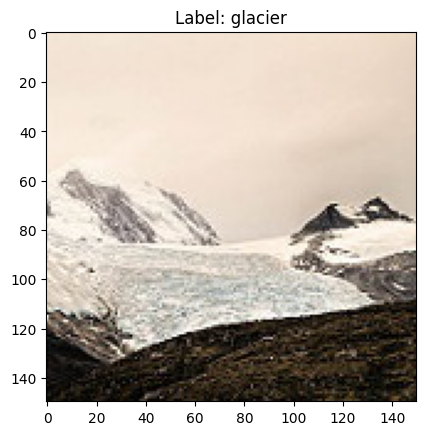

In [14]:
# Define transformation (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")


# show an image func
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()

# Get a batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 1 image
imshow(images[0], title=f"Label: {train_dataset.classes[labels[0]]}")


## CNN Model

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):  # buildings, forest, glacier, mountain, sea, street
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 18 * 18, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



## Train

In [17]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    #metrics
    train_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.4f}")


Epoch 1/5, Loss: 94.5065, Accuracy: 0.9235
Epoch 2/5, Loss: 63.0145, Accuracy: 0.9493
Epoch 3/5, Loss: 56.2305, Accuracy: 0.9555
Epoch 4/5, Loss: 52.2566, Accuracy: 0.9584
Epoch 5/5, Loss: 34.8618, Accuracy: 0.9751


## Evaluation

Accuracy: 0.8353
Precision: 0.8431
Recall: 0.8346
F1-Score: 0.8354

Per-Class Accuracy:
buildings: 73.68%
forest: 90.93%
glacier: 83.18%
mountain: 72.57%
sea: 90.78%
street: 89.62%


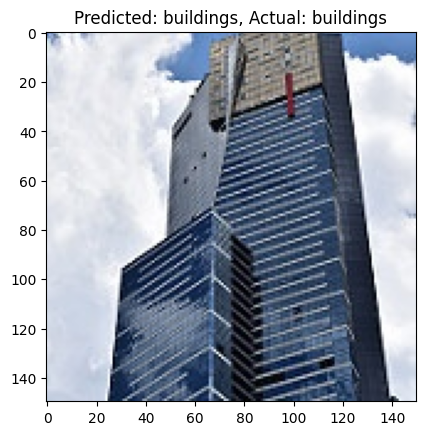

Saved: ./sample_1.png


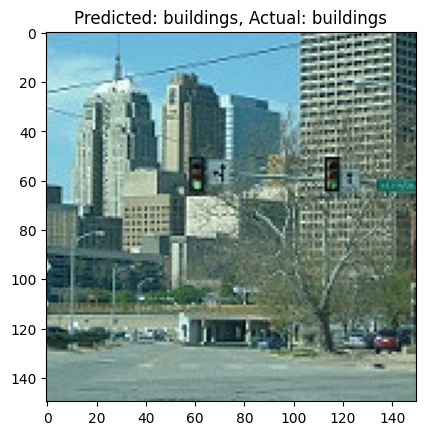

Saved: ./sample_2.png


In [55]:
# from collections import defaultdict
# import os

# Evaluate the model and visualize and save predictions
def evaluate_and_visualize(model, loader, dataset_classes, save_dir=".", num_samples=2):
    model.eval()
    all_preds, all_labels = [], []
    class_correct, class_total = defaultdict(int), defaultdict(int)

    with torch.no_grad():
        # Evaluation loop
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Collect all predictions and labels for overall metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate per-class correct/total
            for label, pred in zip(labels, predicted):
                class_total[label.item()] += 1
                if label == pred:
                    class_correct[label.item()] += 1

        # metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        # Per class accuracy
        print("\nPer-Class Accuracy:")
        per_class_accuracy = {dataset_classes[i]: 100 * class_correct[i] / class_total[i]
                              for i in range(len(dataset_classes))}
        for class_name, acc in per_class_accuracy.items():
            print(f"{class_name}: {acc:.2f}%")

        # save specified number of samples
        data_iter = iter(loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(num_samples):
            img = images[i].cpu()
            plt.figure()
            imshow(img,
                   title=f"Predicted: {dataset_classes[predicted[i]]}, Actual: {dataset_classes[labels[i]]}")
            save_path = f"{save_dir}/sample_{i + 1}.png"
            plt.savefig(save_path)
            plt.close()
            print(f"Saved: {save_path}")

# the merged function
evaluate_and_visualize(model, val_loader, val_dataset.classes, save_dir=".")


## Report

### Intel Image Classification Report

#### Objective
To classify images into six classes (buildings, forest, glacier, mountain, sea,street) using a Convolutional Neural Network (CNN). The dataset includes 14,000 training images, 3,000 validation images.

#### Steps
1. **Dataset Preparation**: Downloaded and organized the dataset into training and validation sets. Used PyTorch's DataLoader to process the images.
2. **Model Architecture**: Built a CNN with three convolutional layers, ReLU activation, MaxPooling, dropout for regularization, and fully connected layers for classification.
3. **Training**: Trained the model for 5 epochs using Adam optimizer and Cross-Entropy Loss.
4. **Evaluation**: Assessed the model on validation data, computing overall accuracy, precision, recall, F1-score, and per-class accuracy.

---

### Results

#### Overall Metrics
| Metric        | Value      |
|---------------|------------|
| Accuracy      | 83.53%     |
| Precision     | 84.31%     |
| Recall        | 83.46%     |
| F1-Score      | 83.54%     |

#### Per-Class Accuracy
| Class         | Accuracy (%) |
|---------------|--------------|
| Buildings     | 73.68        |
| Forest        | 90.93        |
| Glacier       | 83.18        |
| Mountain      | 72.57        |
| Sea           | 90.78        |
| Street        | 89.62        |

---

### Summary
1. The model achieved an overall accuracy of **83.53%** on the validation set (3,000 images).
2. The **highest accuracy** was for the Forest class (90.93%), while the **lowest accuracy** was for the Mountain class (72.57%).
3. The model demonstrates good overall performance with room for improvement in certain classes.
